### Steg 1: Importerar och laddar data

(70000, 784) (70000,)


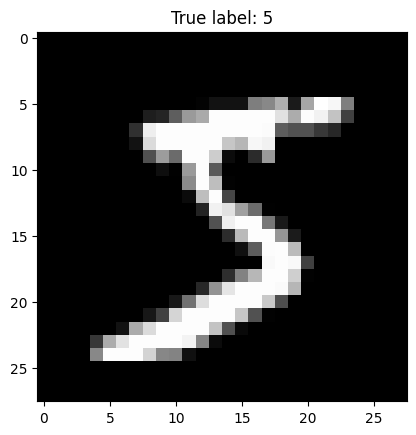

In [ ]:
# Importerar nödvändiga bibliotek
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import cross_val_predict
import time
import joblib

# Laddar MNIST (gråskalebilder 28x28=784 pixlar, labels 0-9)
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
X, y = mnist.data, mnist.target.astype(np.uint8)  # X: (70000,784), y: labels
print(X.shape, y.shape)  # Bekräfta storlek på dataset

# Visualiserar exempel
somedigit = X[0].reshape(28,28)
plt.imshow(somedigit, cmap='gray') #cmap='gray' behåller originaldata. 
plt.title(f'True label: {y[0]}')
plt.show()


Här ser vi direkt att det är svart bakgrund och vit siffra i datasettet. 

### Steg 2: Uppdelning av data (80% träning (inkl. validering i GridSearchCV) 20% test)

In [2]:
# Vi sparar 20% till det allra sista testet, och använder 80% till träning + Cross Validation!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train (för CV): {X_train.shape[0]} bilder, {X_train.shape[1]} pixlar per bild")
print(f"X_test (för final test): {X_test.shape[0]} bilder, {X_test.shape[1]} pixlar per bild")


X_train (för CV): 56000 bilder, 784 pixlar per bild
X_test (för final test): 14000 bilder, 784 pixlar per bild


### Steg 3: EDA

Vi gör EDA endast på träningsdata för att undvika dataläckage


Klasser i X_train:
0    5560
1    6277
2    5610
3    5708
4    5529
5    5040
6    5480
7    5790
8    5468
9    5538
Name: count, dtype: int64

Klasser i % (X_train):
0     9.9
1    11.2
2    10.0
3    10.2
4     9.9
5     9.0
6     9.8
7    10.3
8     9.8
9     9.9
Name: proportion, dtype: float64

Native_dist: Medel 10.0% ± 0.5 % (std)

Pixlar i X_train (min/max/medel):
      0    1    2    3    4    5    6    7    8    9    ...         774  \
min   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.000000   
max   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  254.000000   
mean  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.191929   
std   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    5.875120   

             775         776         777         778        779  780  781  \
min     0.000000    0.000000    0.000000    0.000000   0.000000  0.0  0.0   
max   253.000000  253.000000  253.000000  244.000000  62.000000  0.0  0.0   
mean    0.09739

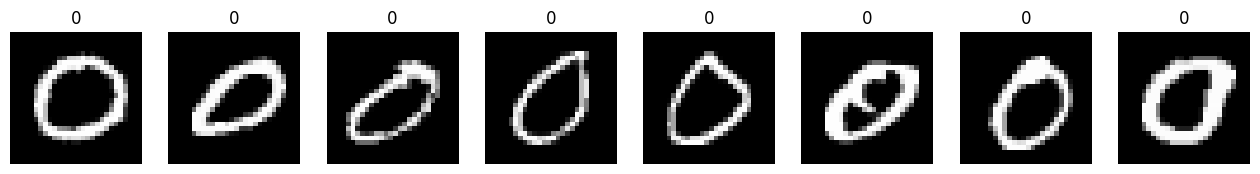

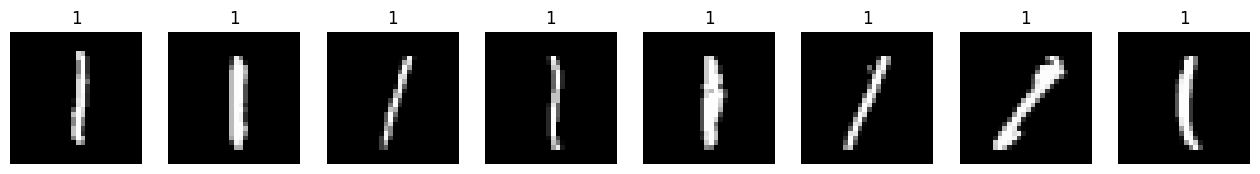

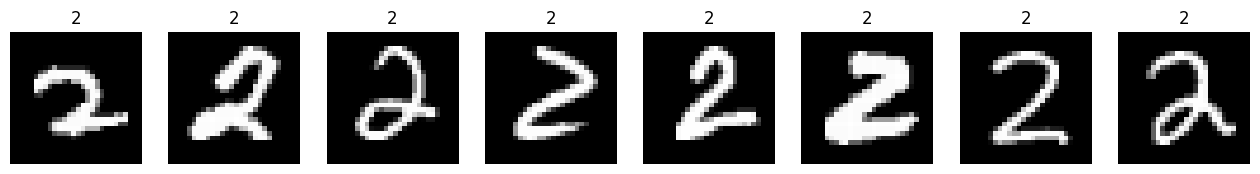

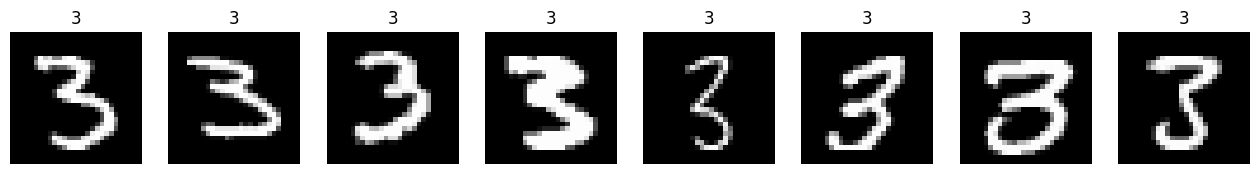

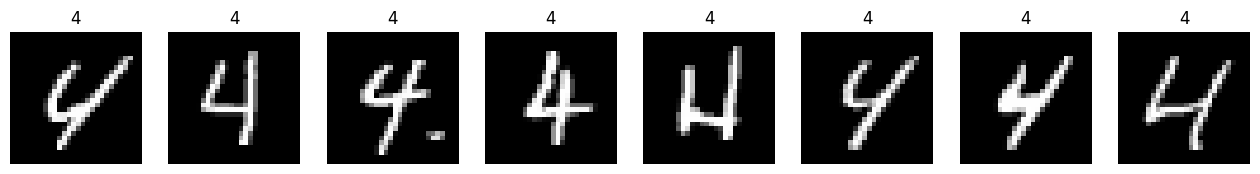

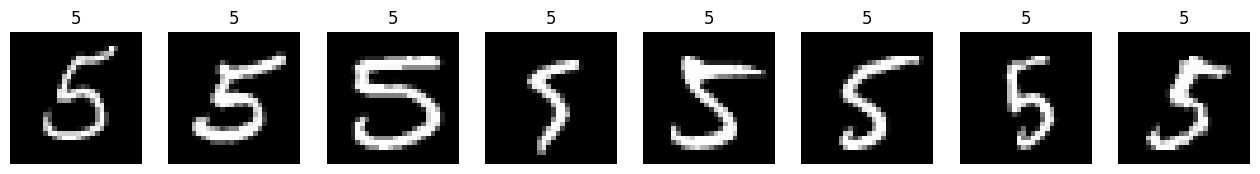

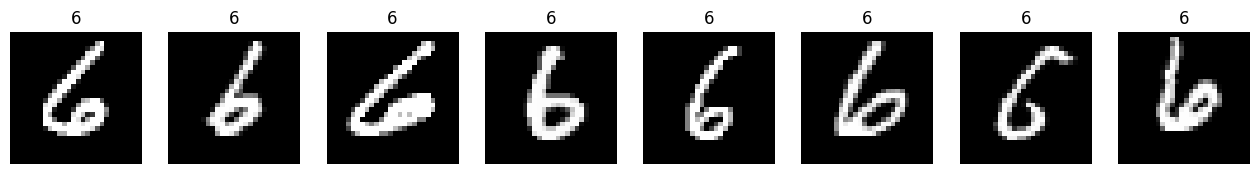

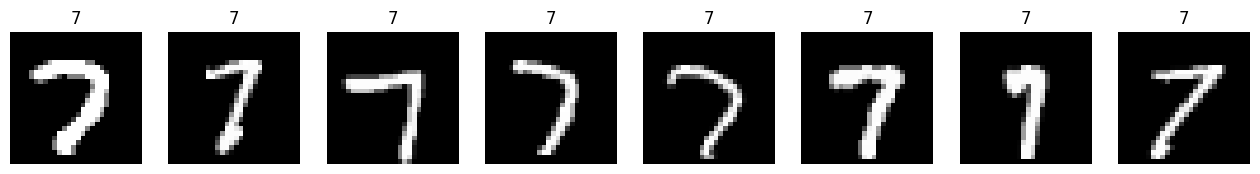

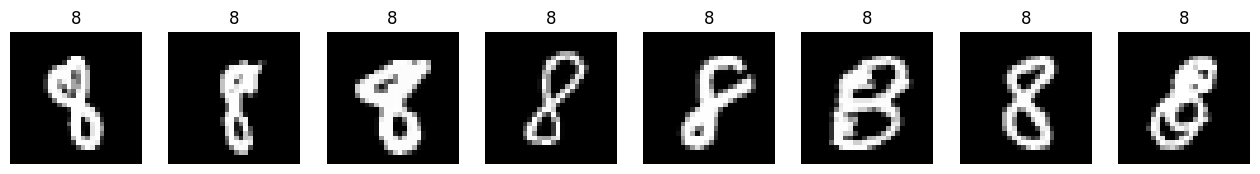

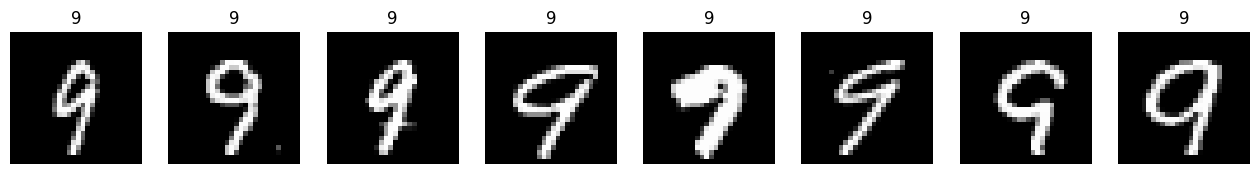

In [3]:
# 1. Klassbalans (hur många 0-9 per set?)
print("\nKlasser i X_train:")
print(pd.Series(y_train).value_counts().sort_index())

native_dist = pd.Series(y_train).value_counts(normalize=True).reindex(range(10), fill_value=0).round(3) * 100
print("\nKlasser i %"+ " (X_train):")
print(native_dist)
print()

native_dist_std = np.std(native_dist, ddof=0).round(1)  # Standardavvikelse i procentenheter
native_dist_mean = np.mean(native_dist).round(1) # Medel i procentenheter

print(f"Native_dist: Medel {native_dist_mean}% ± {native_dist_std} % (std)")

# 2. Pixelintensiteter (min/max/medel)
print("\nPixlar i X_train (min/max/medel):")
print(pd.DataFrame(X_train).describe().loc[['min', 'max', 'mean', 'std']])

# 3. Visa fler bildexempel
def show_digits(X, y, digits=range(10), n=8): # digits=range(10) för 0-9
    for digit in digits:
        idx = np.where(y == digit)[0][:n]  # Första n index med den siffran
        fig, axs = plt.subplots(1, n, figsize=(n*2, 2))
        for i, id_ in enumerate(idx):  # id_ för att undvika 'id' keyword
            img = X[id_].reshape(28, 28)
            axs[i].imshow(img, cmap='gray') # G
            axs[i].set_title(str(digit))
            axs[i].axis('off')
        plt.show()

# Användning (efter split eller på X)
show_digits(X_train, y_train, digits=range(10), n=8) # 8 ex per siffra 0-9



Vi kan se olika saker utan utifrån vår lilla analys. 

Det första är att det råder obalans i klassindelningen, det finns klasser med fler bilder än andra. För att få till en så bra träning som möjligt lägger vi in stratifiering i datauppdelningen nedan.

För det andra har bilderna svart bakgrund och vita siffror. Det kan vi se visuellt men även i pixelanalysen där medelvärdet för pixelintensiteten är väldigt låg, det indikerar en svart dominans i bilden. Detta kommer vi behöva ta itu med när vi sedan tar in ny data från streamlight appen. 

Sist men inte minst ser vi att vissa bilder inte ser ut som dess klassificering, vilket kan orsaka problem vid inläsning av ny osedd data (inte minst i produktion på Streamlit).

 ### Steg 3: Ny data split med stratifiering

Klassfördelning i procent:
 0     9.9
1    11.3
2    10.0
3    10.2
4     9.7
5     9.0
6     9.8
7    10.4
8     9.8
9     9.9
Name: proportion, dtype: float64


Jämförelse klassfördelning:
   Före stratify (%)  Efter stratify (%)  Skillnad (%)
0                9.9                 9.9           0.0
1               11.2                11.3           0.1
2               10.0                10.0           0.0
3               10.2                10.2           0.0
4                9.9                 9.7          -0.2
5                9.0                 9.0           0.0
6                9.8                 9.8           0.0
7               10.3                10.4           0.1
8                9.8                 9.8           0.0
9                9.9                 9.9           0.0

Innan stratify: Medel 10.00% ± 0.52 %
Efter stratify: Medel 10.00% ± 0.55 %
Skillnad i standardavvikelse: +0.04 %


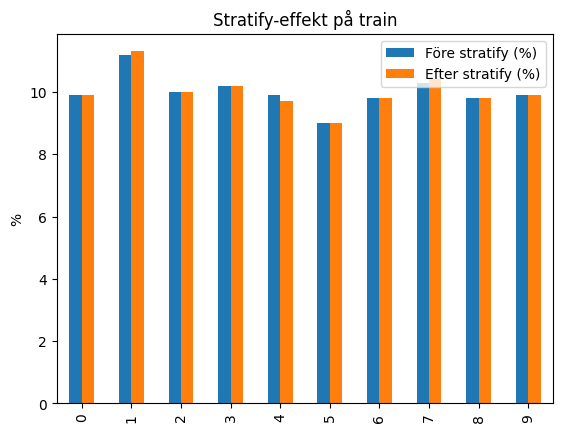

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verifierar
new_dist = pd.Series(y_train).value_counts(normalize=True).reindex(range(10), fill_value=0).round(3) * 100
print("Klassfördelning i procent:\n",new_dist)
print()

 #Jämför före/efter stratify
comparison = pd.DataFrame({
    'Före stratify (%)': native_dist,
    'Efter stratify (%)': new_dist,
    'Skillnad (%)': (new_dist - native_dist).round(1)
}).round(1)

print()

print("Jämförelse klassfördelning:")
print(comparison)

print()

print("Innan stratify:", f"Medel {np.mean(native_dist):.2f}% ± {np.std(native_dist, ddof=0):.2f} %")
print("Efter stratify:", f"Medel {np.mean(new_dist):.2f}% ± {np.std(new_dist, ddof=0):.2f} %")
print("Skillnad i standardavvikelse:", f"{np.std(new_dist, ddof=0) - np.std(native_dist, ddof=0):+.2f} %")

# Visualiserar skillnaden
comparison[['Före stratify (%)', 'Efter stratify (%)']].plot(kind='bar', title='Stratify-effekt på train');
plt.ylabel('%');
plt.legend();


Det var ett intressant fynd detta, att standardavvikelsen skulle öka med stratify. Efter lite efterforskning kan det konstateras att stratify tvingar att spegla hur hela datasetet (träningsdatan i detta fall) ser ut, snarare än att lämna klassfördelningen åt slumpen som endast random state gör. Vi behåller stratify för bättre accuracy sedan.

### Steg 4: Preprocessing

Nu ska vi testa att binarisera! Vi gör detta för att få bort brus i bilden. Det kan hjälpa accuracy och det ska vi sedan utvärdera.

Orginal bild från Train:


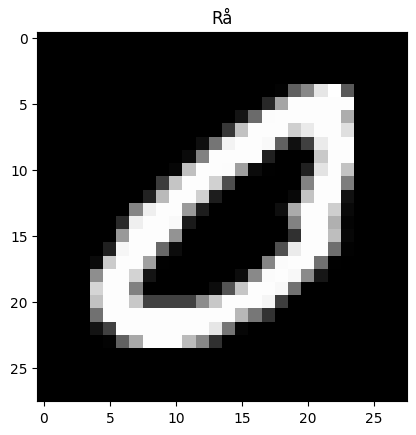

Binariserad bild från Train:


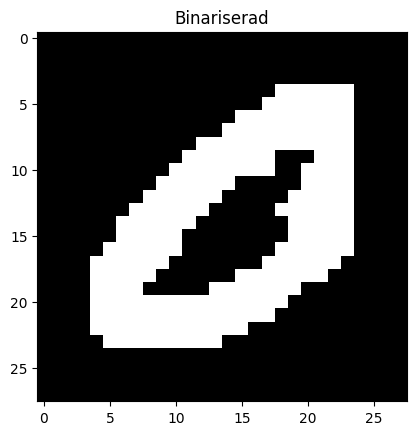

In [5]:
# Binarisering:  förenklar pixlar, går från skalan 0-255 till skalan 0-1. Noise reduction!
X_train_bin = (X_train > 0).astype(int) #Binariserad version av skalad X_train.
X_test_bin = (X_test > 0).astype(int) #Binariserad version av skalad X_test.

# Omskrivning för förtydligande för dataset utan binarisering:
X_train_255 = X_train
X_test_255 = X_test

print("Orginal bild från Train:")
plt.imshow(X_train_255[0].reshape(28,28), cmap='gray'); plt.title('Rå');
plt.show()

print("Binariserad bild från Train:")
plt.imshow(X_train_bin[0].reshape(28,28), cmap='gray'); plt.title('Binariserad');


Nu är det dags att köra skalning på både binära och ickebinära datasetet.

In [6]:
# Skalning (standardisering)
scaler = StandardScaler()

# skalning ickebinärt dataset
X_train_255 = scaler.fit_transform(X_train_255)  # Lär medel/std från train + skalning
X_test_255 = scaler.transform(X_test_255)        # Endast skalning med train-stats

# Verifiering skalning ickebinärt dataset
print("Ickebinärt dataset:")
print()
print("Medelvärde före skalning:", 
      X.mean().round(0) if 'X' in locals() and abs(X.mean()) > 1 else f"{X.mean():.3f} (redan skalad)")

print("Medelvärde efter skalning [train, test]:")
means = np.array([X_train_255.mean(), X_test_255.mean()])
print(means.round(3))

print("Std efter skalning [train, test]:")
stds = np.array([X_train_255.std(), X_test_255.std()])
print(stds.round(3))
print()


# skalning binärt dataset
X_train_bin = scaler.fit_transform(X_train_bin)  # Lär medel/std från train + skalning
X_test_bin = scaler.transform(X_test_bin)        # Endast skalning med train-stats

# Verifiering skalning binärt dataset
print("Binärt dataset:")
print()
print("Medelvärde före skalning:", 
      X.mean().round(0) if 'X' in locals() and abs(X.mean()) > 1 else f"{X.mean():.3f} (redan skalad)")

print("Medelvärde efter skalning [train, test]:")
means = np.array([X_train_bin.mean(), X_test_bin.mean()])
print(means.round(3))

print("Std efter skalning [train, test]:")
stds = np.array([X_train_bin.std(), X_test_bin.std()])
print(stds.round(3))


Ickebinärt dataset:

Medelvärde före skalning: 33.0
Medelvärde efter skalning [train, test]:
[-0.     0.001]
Std efter skalning [train, test]:
[0.957 3.017]

Binärt dataset:

Medelvärde före skalning: 33.0
Medelvärde efter skalning [train, test]:
[-0.    -0.001]
Std efter skalning [train, test]:
[0.957 0.978]


Vi har verifierat att vår scaler fungerar, då medelvärdet är 0 och standardavvikelsen är nära 1. 

Testdata har högre standardavvikelse på ickebinära data vilket är normalt då vi inte har tränat (kört fit) på den, utan endast applicerat receptet från vårt träningsdata. Tittar vi standardavvikelsen på binära testdata kan vi se att den faktiskt är närmare 1, vilket tyder på att binariseringen har lägre variation.

### Steg 5: Modellering

Efter noggrann efterforskning både på nätet och via kollegors fynd har jag valt att utvärdera modellerna RandomForest, ExtraTrees och Logistic Regression. Jag kommer inte använda mig av voting utan endast jämföra dessa två modeller manuellt. Voting känns onödigt om vi redan har två trädmodeller som i sig är röstningskommitteér. Jag har valt bort SVC modellen då den är orimligt tidskrävande att träna på en standard businessdator. Jag har däremot läst att den ska presentera riktigt bra. 


=== ICKEBINÄRT ===
Fitting 5 folds for each of 4 candidates, totalling 20 fits
RandomForest: CV Accuracy 0.9670 - Time: 181.8 s
Fitting 5 folds for each of 4 candidates, totalling 20 fits
ExtraTrees: CV Accuracy 0.9701 - Time: 242.3 s
Fitting 5 folds for each of 2 candidates, totalling 10 fits
LogisticRegression: CV Accuracy 0.9189 - Time: 131.9 s

=== BINÄRT ===
Fitting 5 folds for each of 4 candidates, totalling 20 fits
RandomForest: CV Accuracy 0.9676 - Time: 132.6 s
Fitting 5 folds for each of 4 candidates, totalling 20 fits
ExtraTrees: CV Accuracy 0.9711 - Time: 234.5 s
Fitting 5 folds for each of 2 candidates, totalling 10 fits
LogisticRegression: CV Accuracy 0.9076 - Time: 131.3 s

JÄMFÖRELSE:
  Preprocessor               Model  CV Accuracy  Time (sec)  \
4       Binärt          ExtraTrees       0.9711       234.5   
1   Ickebinärt          ExtraTrees       0.9701       242.3   
3       Binärt        RandomForest       0.9676       132.6   
0   Ickebinärt        RandomForest   

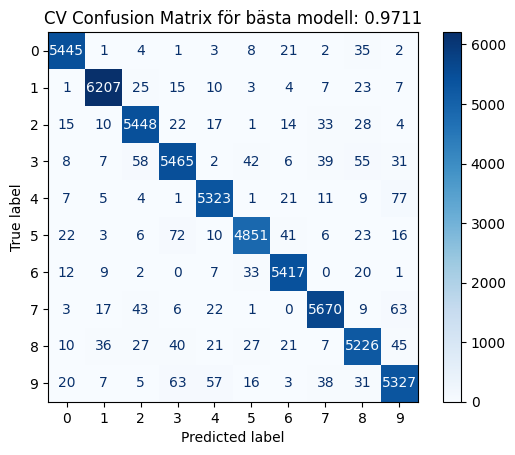

In [ ]:
datasets = {
    'Ickebinärt': (X_train_255, y_train),
    'Binärt': (X_train_bin, y_train)
}

results = []
best_pipelines = {}  # Spara bästa setup per preprocessing + modell

# 1. Vi lägger upp modellerna i en lista så vi enkelt kan iterera över dem
models_to_test = [
    ('RandomForest', RandomForestClassifier(random_state=42, n_jobs=-1)), 
    ('ExtraTrees', ExtraTreesClassifier(random_state=42, n_jobs=-1)),
    ('LogisticRegression', LogisticRegression(random_state=42)) 
]

for preprocessing_name, (X_tr, y_tr) in datasets.items():
    print(f"\n=== {preprocessing_name.upper()} ===")
    
    for mname, model_inst in models_to_test:
        pipe = Pipeline([('model', model_inst)])
        
        # Ge rätt hyperparametrar till rätt modell
        if mname in ['RandomForest', 'ExtraTrees']:
            param_grid = {
                'model__n_estimators': [50, 100], 
                'model__max_depth': [None, 10]
            }
        else:
            param_grid = {
                'model__C': [0.1, 1.0],      
                'model__max_iter': [1000]    
            }
        
        start_time = time.time()
        
        # Korsvalidering på X_train
        grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
        grid.fit(X_tr, y_tr)
        
        # GridSearchs egna score
        cv_acc = grid.best_score_
        
        tid_sekunder = round(time.time() - start_time, 1)
        
        results.append({
            'Preprocessor': preprocessing_name,
            'Model': mname,
            'CV Accuracy': round(cv_acc, 4),
            'Time (sec)': tid_sekunder,
            'Bästa hyperparametrar': grid.best_params_
        })
        
        best_pipelines[f"{preprocessing_name}_{mname}"] = grid.best_estimator_
        print(f"{mname}: CV Accuracy {cv_acc:.4f} - Time: {tid_sekunder} s")

# Tabell
pd.set_option('display.max_colwidth', None)
df = pd.DataFrame(results).sort_values('CV Accuracy', ascending=False)
print("\nJÄMFÖRELSE:")
print(df)

# Bästa modell
best_preprocessing_model = df.iloc[0]['Preprocessor'] + '_' + df.iloc[0]['Model']
best_pipe = best_pipelines[best_preprocessing_model]
best_acc = df.iloc[0]['CV Accuracy']
print(f"\nVINNARE: {best_preprocessing_model} med {best_acc} CV Accuracy!")



# ConfusionMatrix för bästa modell under CV
y_cv_pred = cross_val_predict(best_pipe, datasets[best_preprocessing_model.split('_')[0]][0], y_train, cv=5, n_jobs=-1)
cm = confusion_matrix(y_train, y_cv_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title(f"CV Confusion Matrix för bästa modell: {best_acc}")
plt.show()


Det var fina resultat vi fick, med mycket höga tal på diagonalen i vår Confusion Matrix, härligt att binariseringen gav effekt! Modellen har det lättare att bearbeta ettor och nollor (förväntat) i de vinnande två av tre modellerna. Intressant är dock att den binariserade ExtraTree-modellen tog längre tid än den vanliga. Vi går vidare med den vinnande modellen och försöker optimera hyperparametrarna ytterligare.

Tittar vi noga på bilden ser vi ett axplock var modellen har det svårast:

4 vs 9: Det finns 77 fall där en 4:a har misstagits för en 9:a.

5 vs 3: 72 fall där en 5:a har misstagits för en 3:a.

7 vs 9: 63 fall där en 7:a har misstagits för en 9:a.

3 vs 2: 58 fall där en 3:a har misstagits för en 2:a.

Vi fokuserar enbart på vinnaren nu, och finjusterar den ytterligare. Vi kör på 100 och 200 träd i ExtraTrees, utmanar max_depth=None med högre tal än 10 som vi hade tidigare, samt lägger till 'model__min_samples_split' och 'model__max_features' för att se hur långt vi kan pressa modellen. Vi får se om det ger högre accuracy (om det ens gör det). Vi kommer även utvärdera överanpassning!

In [8]:
print("Startar finjusteringen av binärt_ExtraTrees...")

# Definierar pipelinen (utan binariseringen)
final_pipe = Pipeline([
    ('model', ExtraTreesClassifier(random_state=42, n_jobs=-1))
])

# Hyperparametrar att testa 
final_param_grid = {
    'model__n_estimators': [100, 200],         # Kan 200 träd bli bättre?
    'model__max_depth': [None, 30, 50],        # Vi testar ett specifikt högre djup än 10 mot None
    'model__min_samples_split': [2, 5],        # Vi testar standard mot ett högre krav för split
    'model__max_features': ['sqrt']            # Vi håller oss till "sqrt" för att snabba upp trädbyggandet
}

# Kör GridSearch
final_grid = GridSearchCV(final_pipe, final_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# --- STARTA TIMERN ---
start_tid = time.time()

# Fit med binarisering då det var bäst i första omgången
final_grid.fit(X_train_bin, y_train)

# --- STOPPA TIMERN ---
slut_tid = time.time()
kord_tid = slut_tid - start_tid

minuter, sekunder = divmod(kord_tid, 60)
print(f"\nGridSearch slutförd! Total tid: {int(minuter)} minuter och {sekunder:.1f} sekunder.")

# Bästa accuracy
final_cv_acc = final_grid.best_score_

print(f"Bästa CV Accuracy: {final_cv_acc:.4f}")
print(f"Bästa parametrar: {final_grid.best_params_}")

# --- BESIKTNING ---
print("\n--- BESIKTNING AV VINNANDE MODELL ---")
print(f"Tränings-accuracy (Mean CV): {final_cv_acc:.4f}")


Startar finjusteringen av binärt_ExtraTrees...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

GridSearch slutförd! Total tid: 25 minuter och 8.9 sekunder.
Bästa CV Accuracy: 0.9724
Bästa parametrar: {'model__max_depth': 30, 'model__max_features': 'sqrt', 'model__min_samples_split': 2, 'model__n_estimators': 200}

--- BESIKTNING AV VINNANDE MODELL ---
Tränings-accuracy (Mean CV): 0.9724


### Steg 6: Testdata

Vi har fått marginellt bättre resultat efter en 25+ minuterskörning på utforskning av hyperparametrar. Skönt att vi hittade ett annat max-depth än None så att vi kan begränsa modellen. Det bedöms att vi har svårt att prestera så mycket bättre än så här i denna modell med tanke på avtagande avkastning. Med en accuracy på ungefär 97% är vi nöjda och kör vidare mot testdata.

In [9]:
print("--- DEN STORA FINALEN: UTVÄRDERING PÅ OSEDD TESTDATA ---")

# GridSearch har redan sparat den absolut bästa modellen åt oss
best_final_model = final_grid.best_estimator_

# Vi kör modellen på den helt osedda (binariserade) testdatan
y_pred_test = best_final_model.predict(X_test_bin) 
test_acc = accuracy_score(y_test, y_pred_test)

# Den ultimata jämförelsen!
print(f"CV-accuracy (från tidigare): {final_cv_acc:.4f}")
print(f"Slutgiltig Test-accuracy:             {test_acc:.4f}")
print(f"Skillnad (Gap):                       {abs(final_cv_acc - test_acc):.4f}")

if abs(final_cv_acc - test_acc) < 0.01:
    print("\nSUCCÉ! Modellen presterar i princip identiskt på helt osedd data.")
    print("Detta bevisar att vi har en otroligt robust modell!")
else:
    print("\nOBSERVERA: Det finns ett märkbart gap mellan CV och test (> 1%).")
    print("Detta indikerar att våra val av hyperparametrar kan ha blivit något överanpassade mot träningsmängden.")
    print("Modellen är fortfarande stark, men detta gap är en perfekt analytisk detalj att titta närmare på i nästa projekt")


--- DEN STORA FINALEN: UTVÄRDERING PÅ OSEDD TESTDATA ---
CV-accuracy (från tidigare): 0.9724
Slutgiltig Test-accuracy:             0.9724
Skillnad (Gap):                       0.0000

SUCCÉ! Modellen presterar i princip identiskt på helt osedd data.
Detta bevisar att vi har en otroligt robust modell!


Jag får säga att jag är mycket nöjd med detta resultat, med tanke på att vi inte har kört en SVC-modell. Nu ska vi bara träna om modellen på hela datasetet och sedan vidare till Streamlit-appen...


### Steg 7: Träning på hela datasetet samt export

In [10]:
# ==========================================
# 100% DATA FÖR APPEN (APP-EXPORT)
# ==========================================
print("\nRetrain på 100% av all data inför export!")

# BINARISERA HELA ORIGINAL-X!
X_all_bin = (X > 0).astype(int)

# Skapar den ultimata scalern
final_scaler = StandardScaler()

# Skalar den BINÄRA datan
X_all_scaled = final_scaler.fit_transform(X_all_bin)

# Träna den bästa modellen på 100% binariserad & skalad data
best_final_model.fit(X_all_scaled, y)

# SPARA MODELL + SCALER
joblib.dump(best_final_model, 'best_model_deploy.joblib')
joblib.dump(final_scaler, 'scaler_deploy.joblib')

print("Modell och scaler exporterade framgångsrikt!")


Retrain på 100% av all data inför export!
Modell och scaler exporterade framgångsrikt!


### Slutord

Det har verkligen varit en lärorik och rolig uppgift att skapa en klassificeringsmodell på MNIST-datasetet. 
Att jämföra olika modeller och få dyka ner i detaljer som hur binarisering av pixlar kan öka modellens prestanda har varit otroligt spännande.

Jag ser fram emot att skapa fler ML-modeller framöver, förhoppningsvis med kraftfullare dator :)